Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


In [1]:
import random
from collections import deque, defaultdict
import logging

logging.basicConfig(format="%(message)s", level=logging.INFO)

In [2]:
from matplotlib import pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

# Tree Search

## Problem

Given an array of positive integers, find the minimum number of elements from a vector that sum to a given number.

In [3]:
def problem(array_length):
    random.seed(array_length)
    array = [random.randint(1, 100) for _ in range(array_length)]
    goal = sum(random.sample(array, array_length // 2))
    logging.info(f"{array} -> {goal}")
    return array, goal

## Breadth-first

In [4]:
def tree_search_bf(blocks, goal):
    search_tree = nx.DiGraph()
    frontier = deque()

    frontier.append(((), tuple(blocks)))

    n = 0
    while frontier:
        n += 1
        current_bag, available_blocks = frontier.popleft()
        search_tree.add_node(current_bag)
        search_tree.nodes[current_bag]["color"] = "yellow"
        search_tree.nodes[current_bag]["order"] = n
        search_tree.nodes[current_bag]["count"] = 1

        if sum(current_bag) == goal:
            print(f"Found a solution in {n:,} steps\n\t{current_bag}")
            search_tree.nodes[current_bag]["color"] = "lime"
            break
        search_tree.nodes[current_bag]["color"] = "royalblue"
        for i, object in enumerate(available_blocks):
            new_state = (
                tuple(sorted((*current_bag, object))),
                tuple(available_blocks[:i] + available_blocks[i + 1 :]),
            )
            if new_state[0] not in search_tree:
                search_tree.add_node(new_state[0], color="lavender", count=0)
                search_tree.add_edge(current_bag, new_state[0], label=object)
            search_tree.nodes[new_state[0]]["count"] += 1
            frontier.append(new_state)

    search_tree.nodes[()]["color"] = "navy"
    return search_tree

[42, 20, 51, 84, 7, 10, 69] -> 100


Found a solution in 58 steps
	(7, 42, 51)


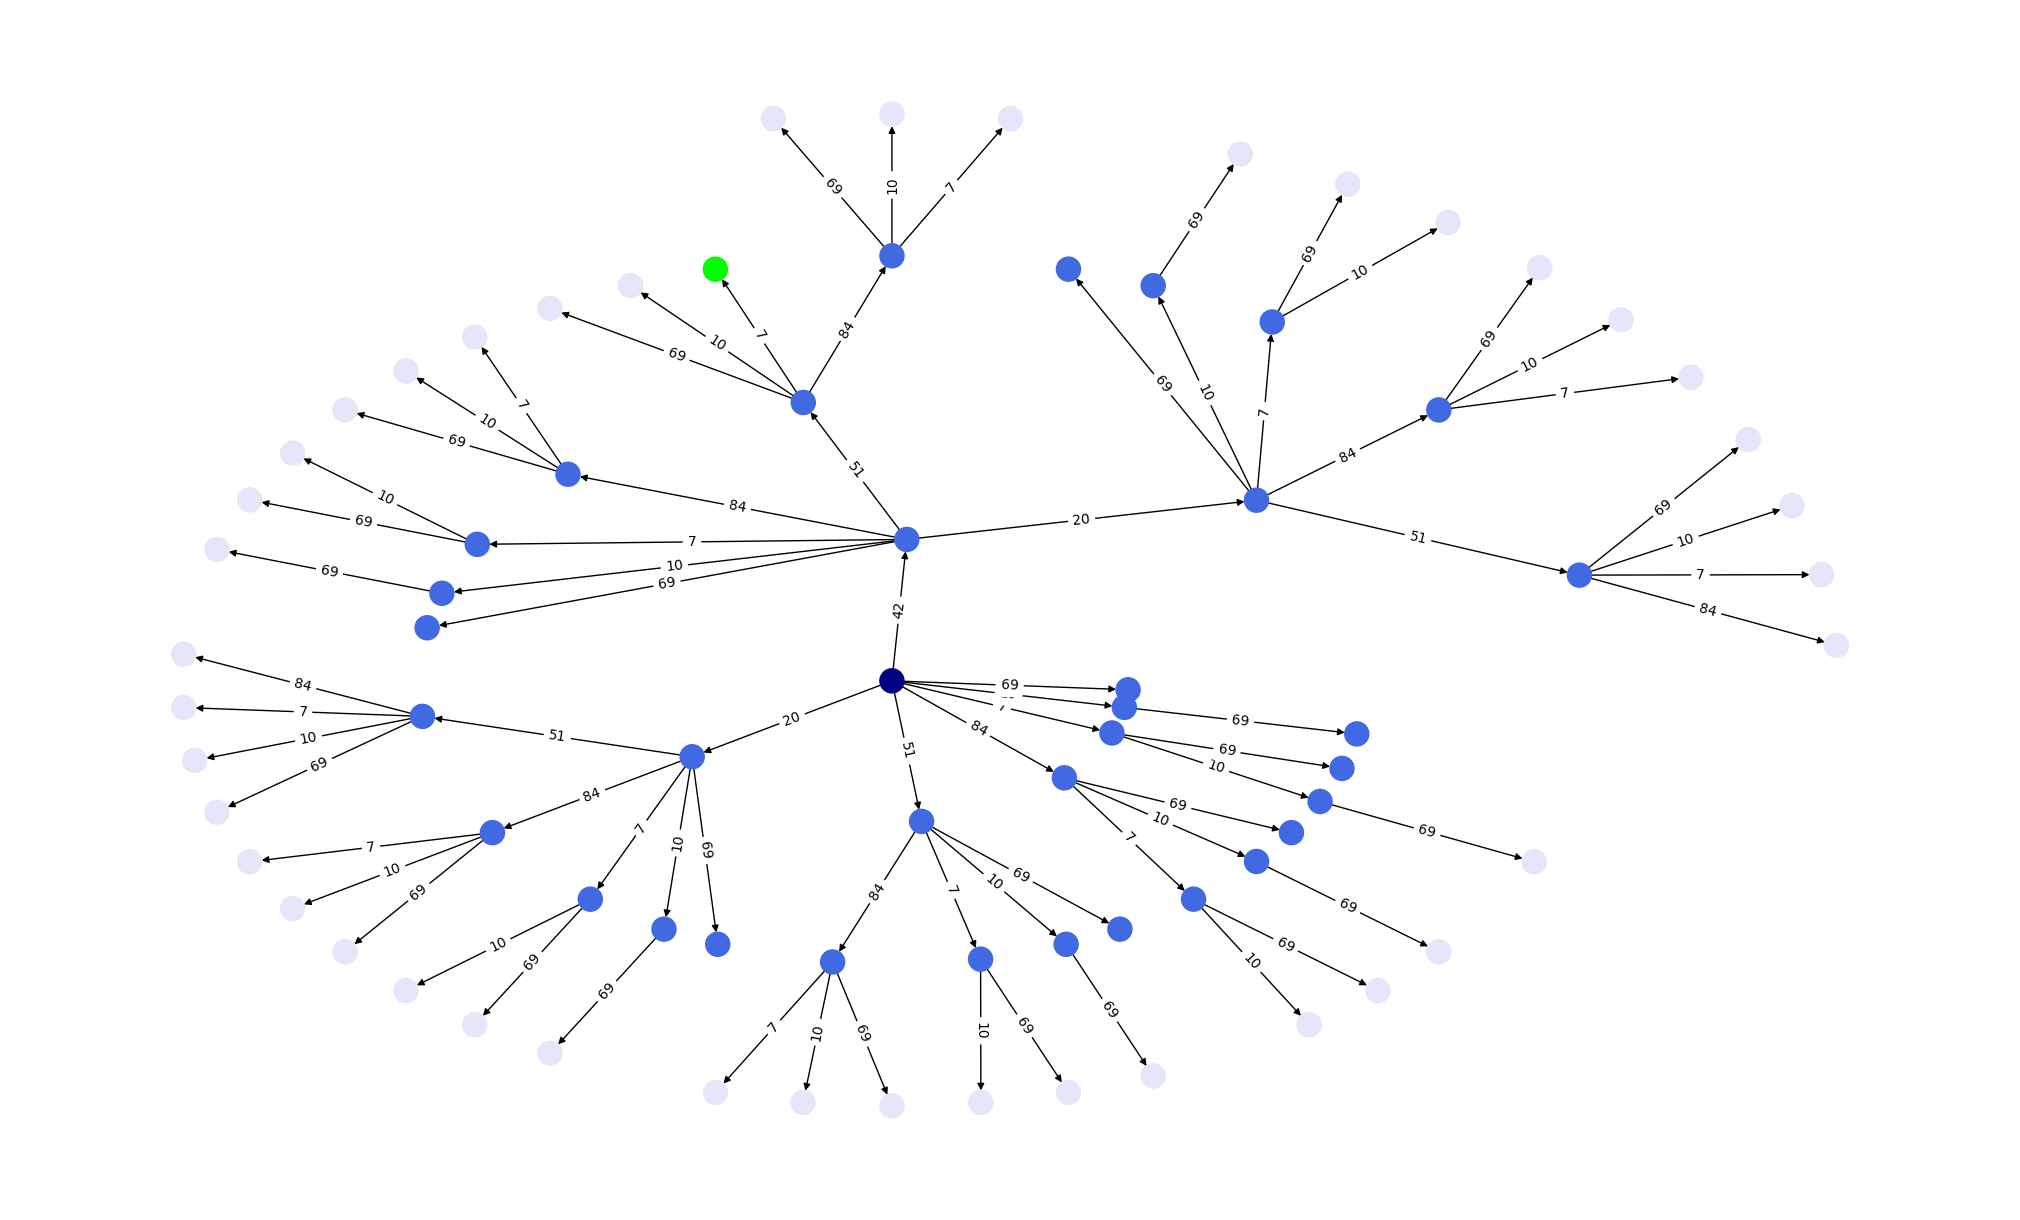

In [5]:
array, goal = problem(7)
search_tree = tree_search_bf(array, goal)

plt.figure(figsize=(20, 12))
pos = graphviz_layout(search_tree, prog="twopi")  # dot neato twopi circo fdp sfdp
nx.draw(
    search_tree,
    pos=pos,
    node_color=[c for _, c in search_tree.nodes(data="color")],
    with_labels=False,
)
nx.draw_networkx_edge_labels(search_tree, pos=pos, edge_labels=nx.get_edge_attributes(search_tree, "label"))
None

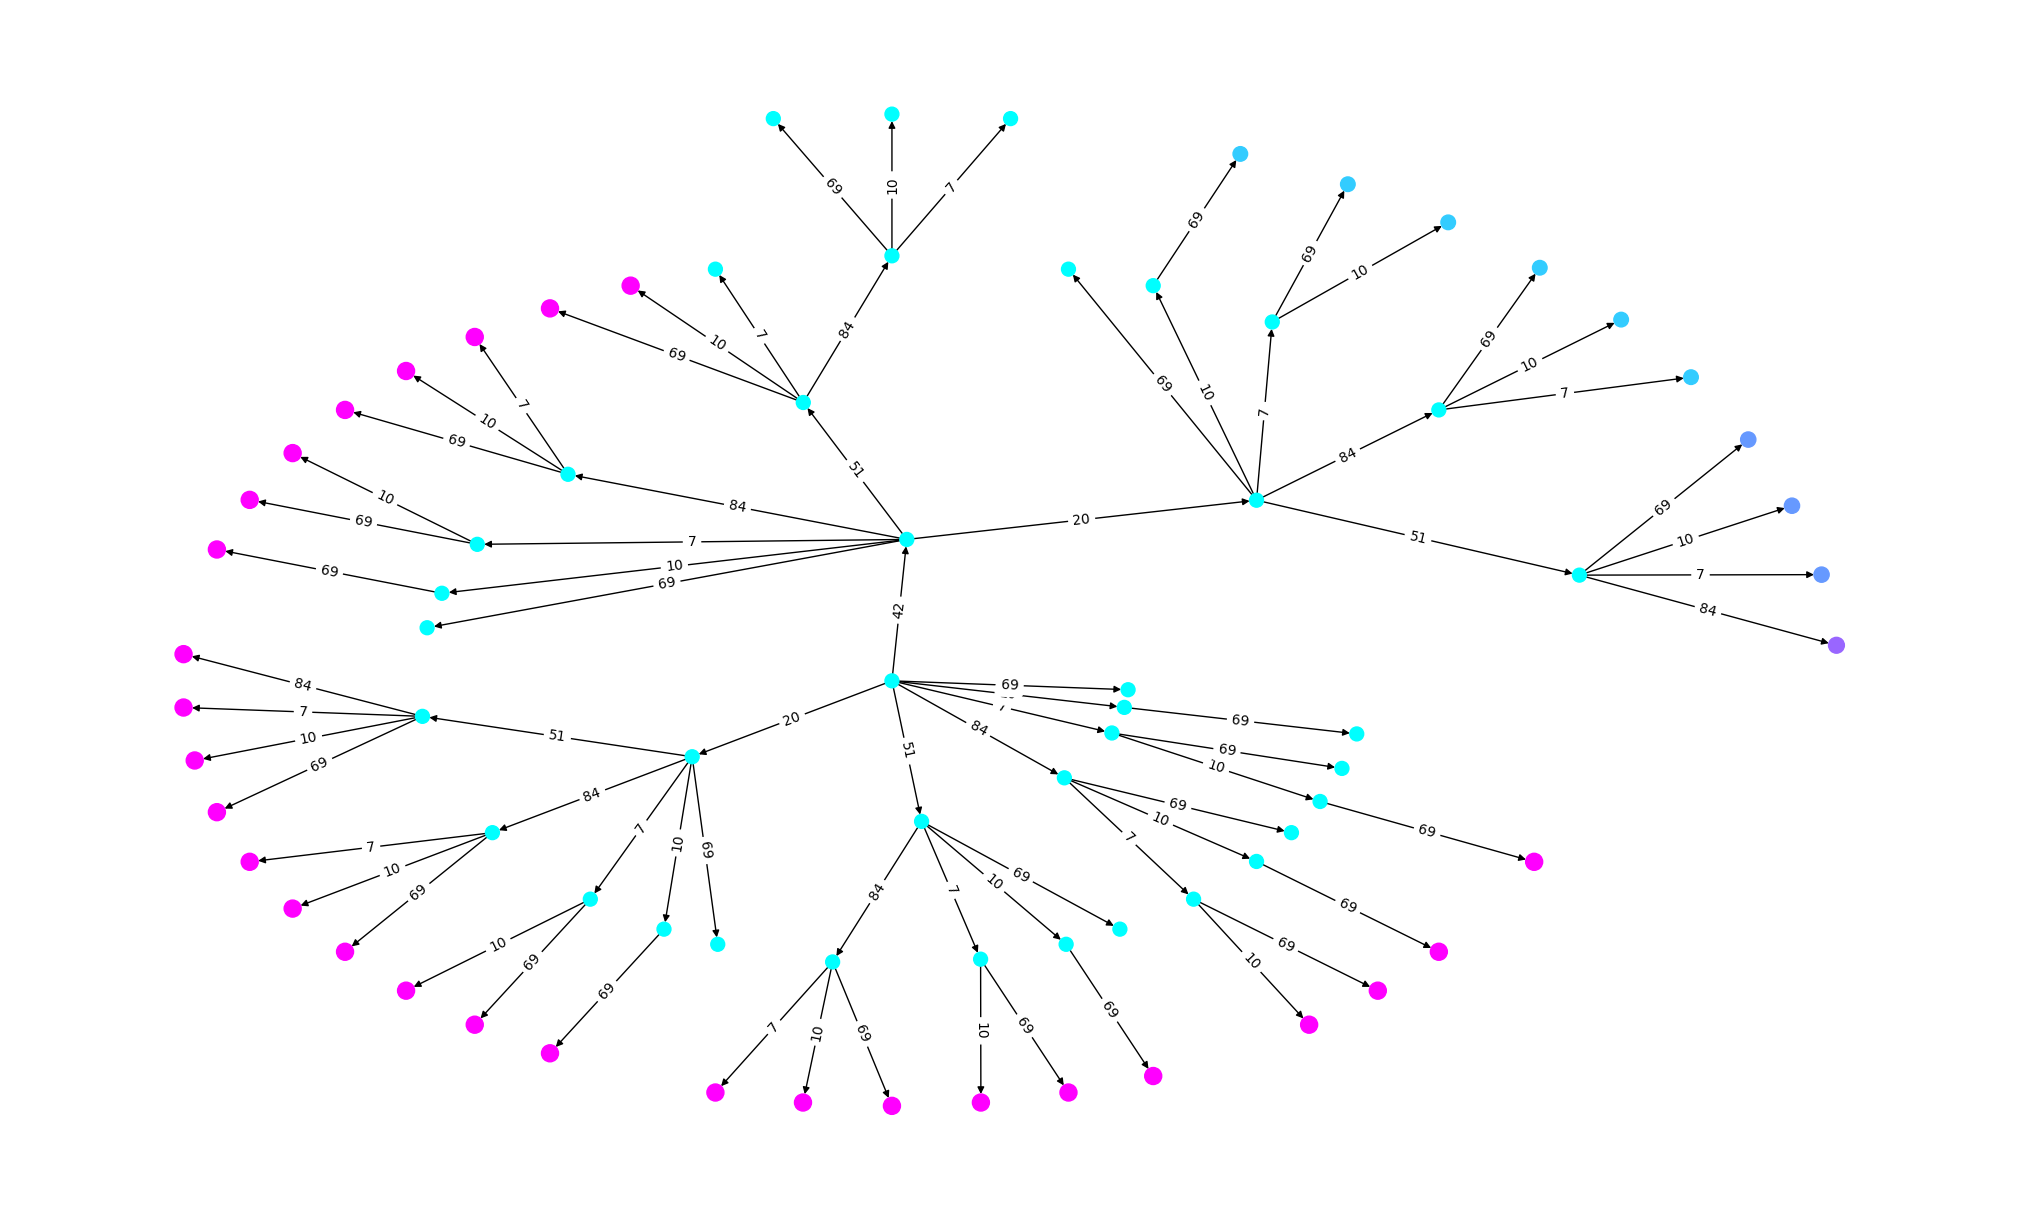

In [6]:
plt.figure(figsize=(20, 12))
nx.draw(
    search_tree,
    pos=pos,
    node_color=[c for _, c in search_tree.nodes(data="count")],
    cmap=plt.cm.cool,
    node_size=[90 + 10 * c for _, c in search_tree.nodes(data="count")],
    with_labels=False,
)
nx.draw_networkx_edge_labels(search_tree, pos=pos, edge_labels=nx.get_edge_attributes(search_tree, "label"))
None

[14, 79, 90, 97, 84, 68, 32, 35, 95, 33, 38, 94, 10, 85] -> 386


Found a solution in 45,045 steps
	(35, 79, 85, 90, 97)


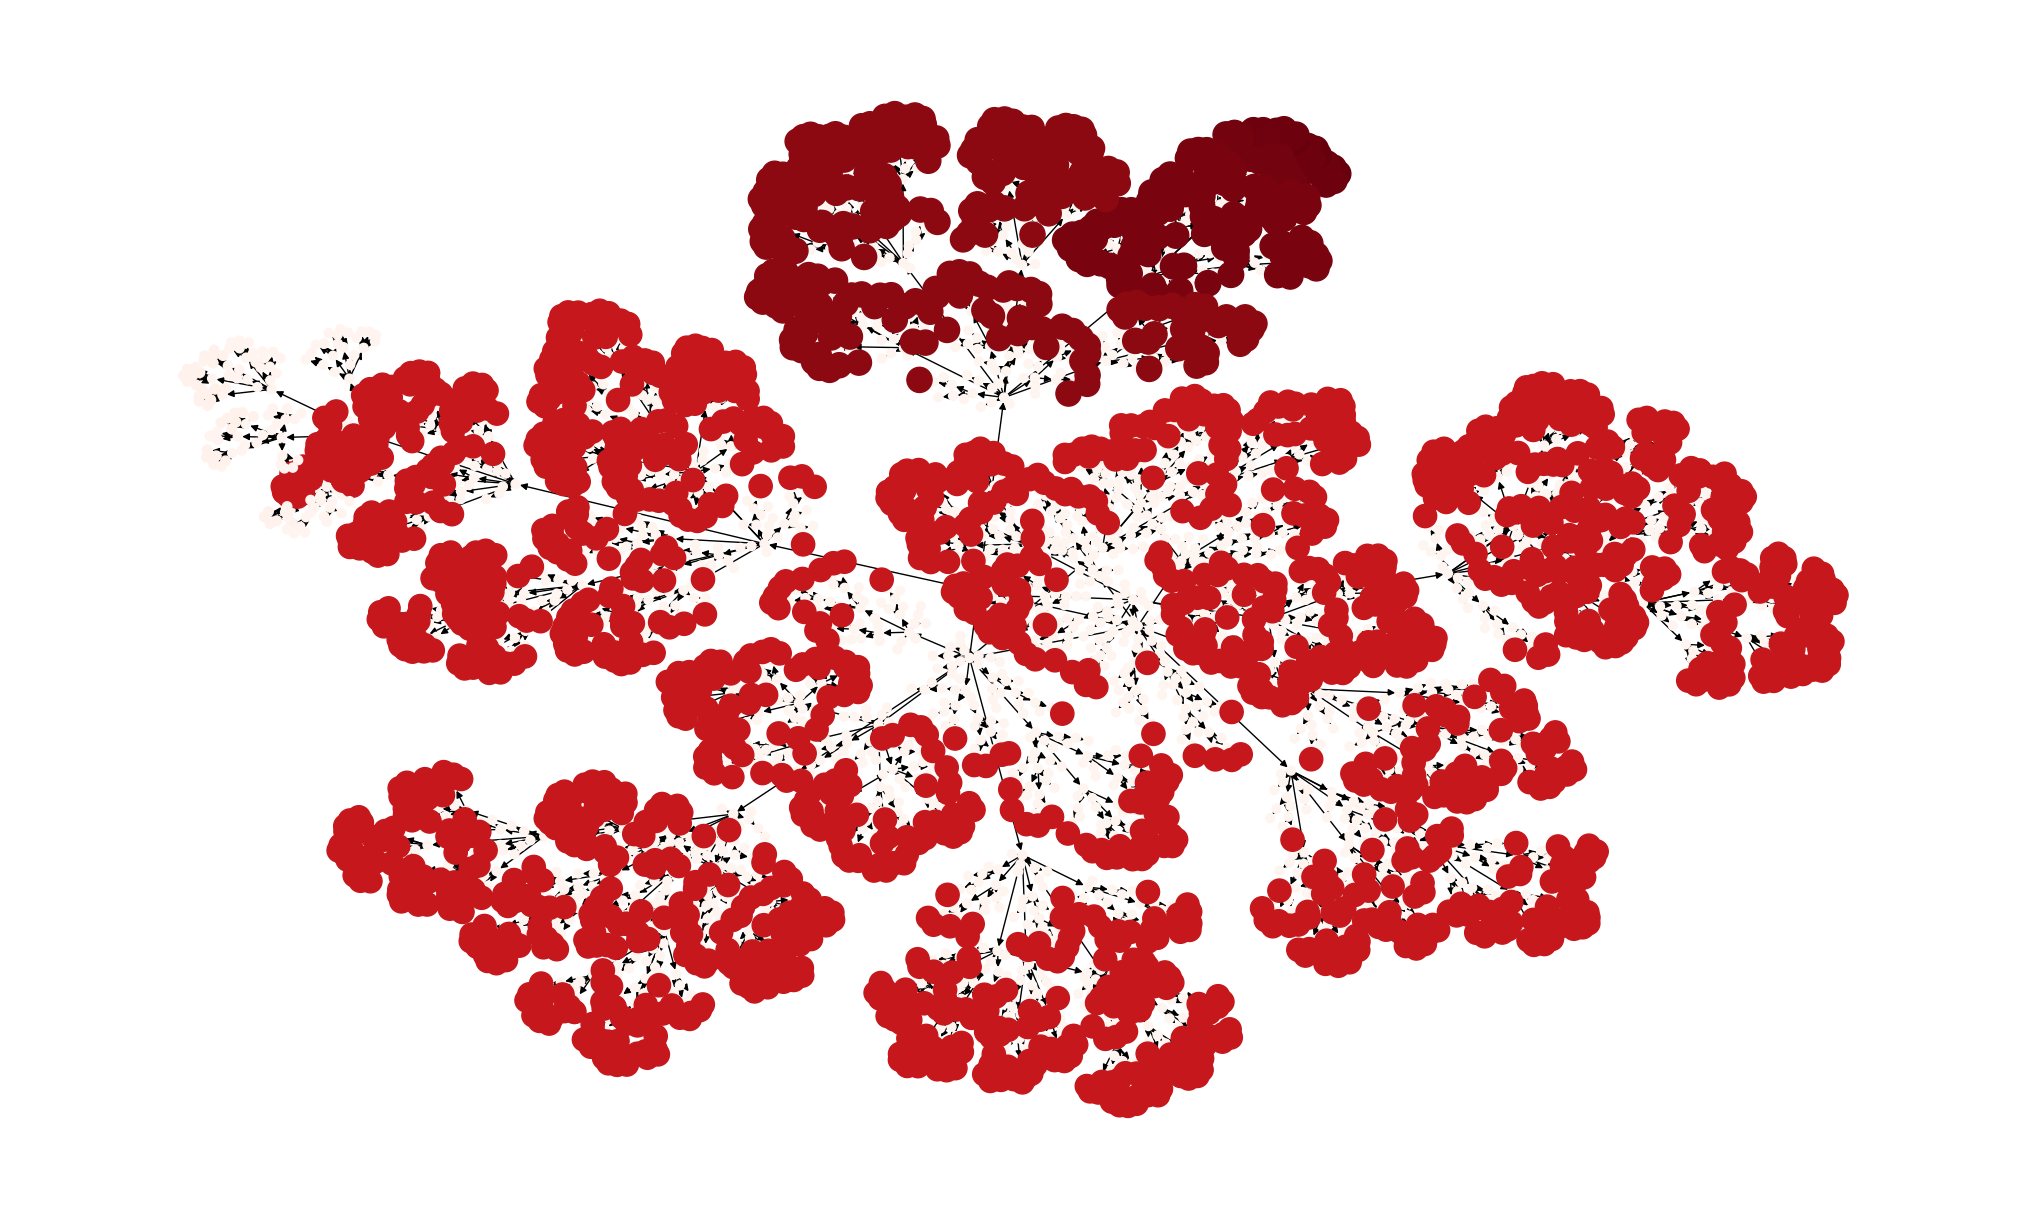

In [7]:
array, goal = problem(14)
search_tree = tree_search_bf(array, goal)

plt.figure(figsize=(20, 12))
pos = graphviz_layout(search_tree, prog="sfdp")  # dot neato twopi circo fdp sfdp
nx.draw(
    search_tree,
    pos=pos,
    node_color=[c for _, c in search_tree.nodes(data="count")],
    node_size=[40 + 2 * c for _, c in search_tree.nodes(data="count")],
    cmap=plt.cm.Reds,
    with_labels=False,
)

## Depth-first + Bound

In [8]:
def tree_search_df(blocks, goal, bound=False):
    search_tree = nx.DiGraph()
    frontier = deque()

    frontier.append(((), tuple(blocks)))

    n = 0
    while frontier:
        n += 1
        current_bag, available_blocks = frontier.pop()
        search_tree.add_node(current_bag)
        search_tree.nodes[current_bag]["color"] = "yellow"
        search_tree.nodes[current_bag]["order"] = n
        search_tree.nodes[current_bag]["count"] = 1

        if sum(current_bag) == goal:
            print(f"Found a solution in {n:,} steps\n\t{current_bag}")
            search_tree.nodes[current_bag]["color"] = "lime"
            break
        if bound and sum(current_bag) > goal:
            search_tree.nodes[current_bag]["color"] = "red"
            continue
        search_tree.nodes[current_bag]["color"] = "royalblue"
        for i, object in enumerate(available_blocks):
            new_state = (
                tuple(sorted((*current_bag, object))),
                tuple(available_blocks[:i] + available_blocks[i + 1 :]),
            )
            if new_state[0] not in search_tree:
                search_tree.add_node(new_state[0], color="lavender", count=0)
                search_tree.add_edge(current_bag, new_state[0], label=object)
            search_tree.nodes[new_state[0]]["count"] += 1
            frontier.append(new_state)

    search_tree.nodes[()]["color"] = "navy"
    return search_tree

[58, 72, 100, 60, 58, 66, 76, 25, 24, 66, 61] -> 359


Found a solution in 20,882 steps
	(24, 60, 61, 66, 72, 76)


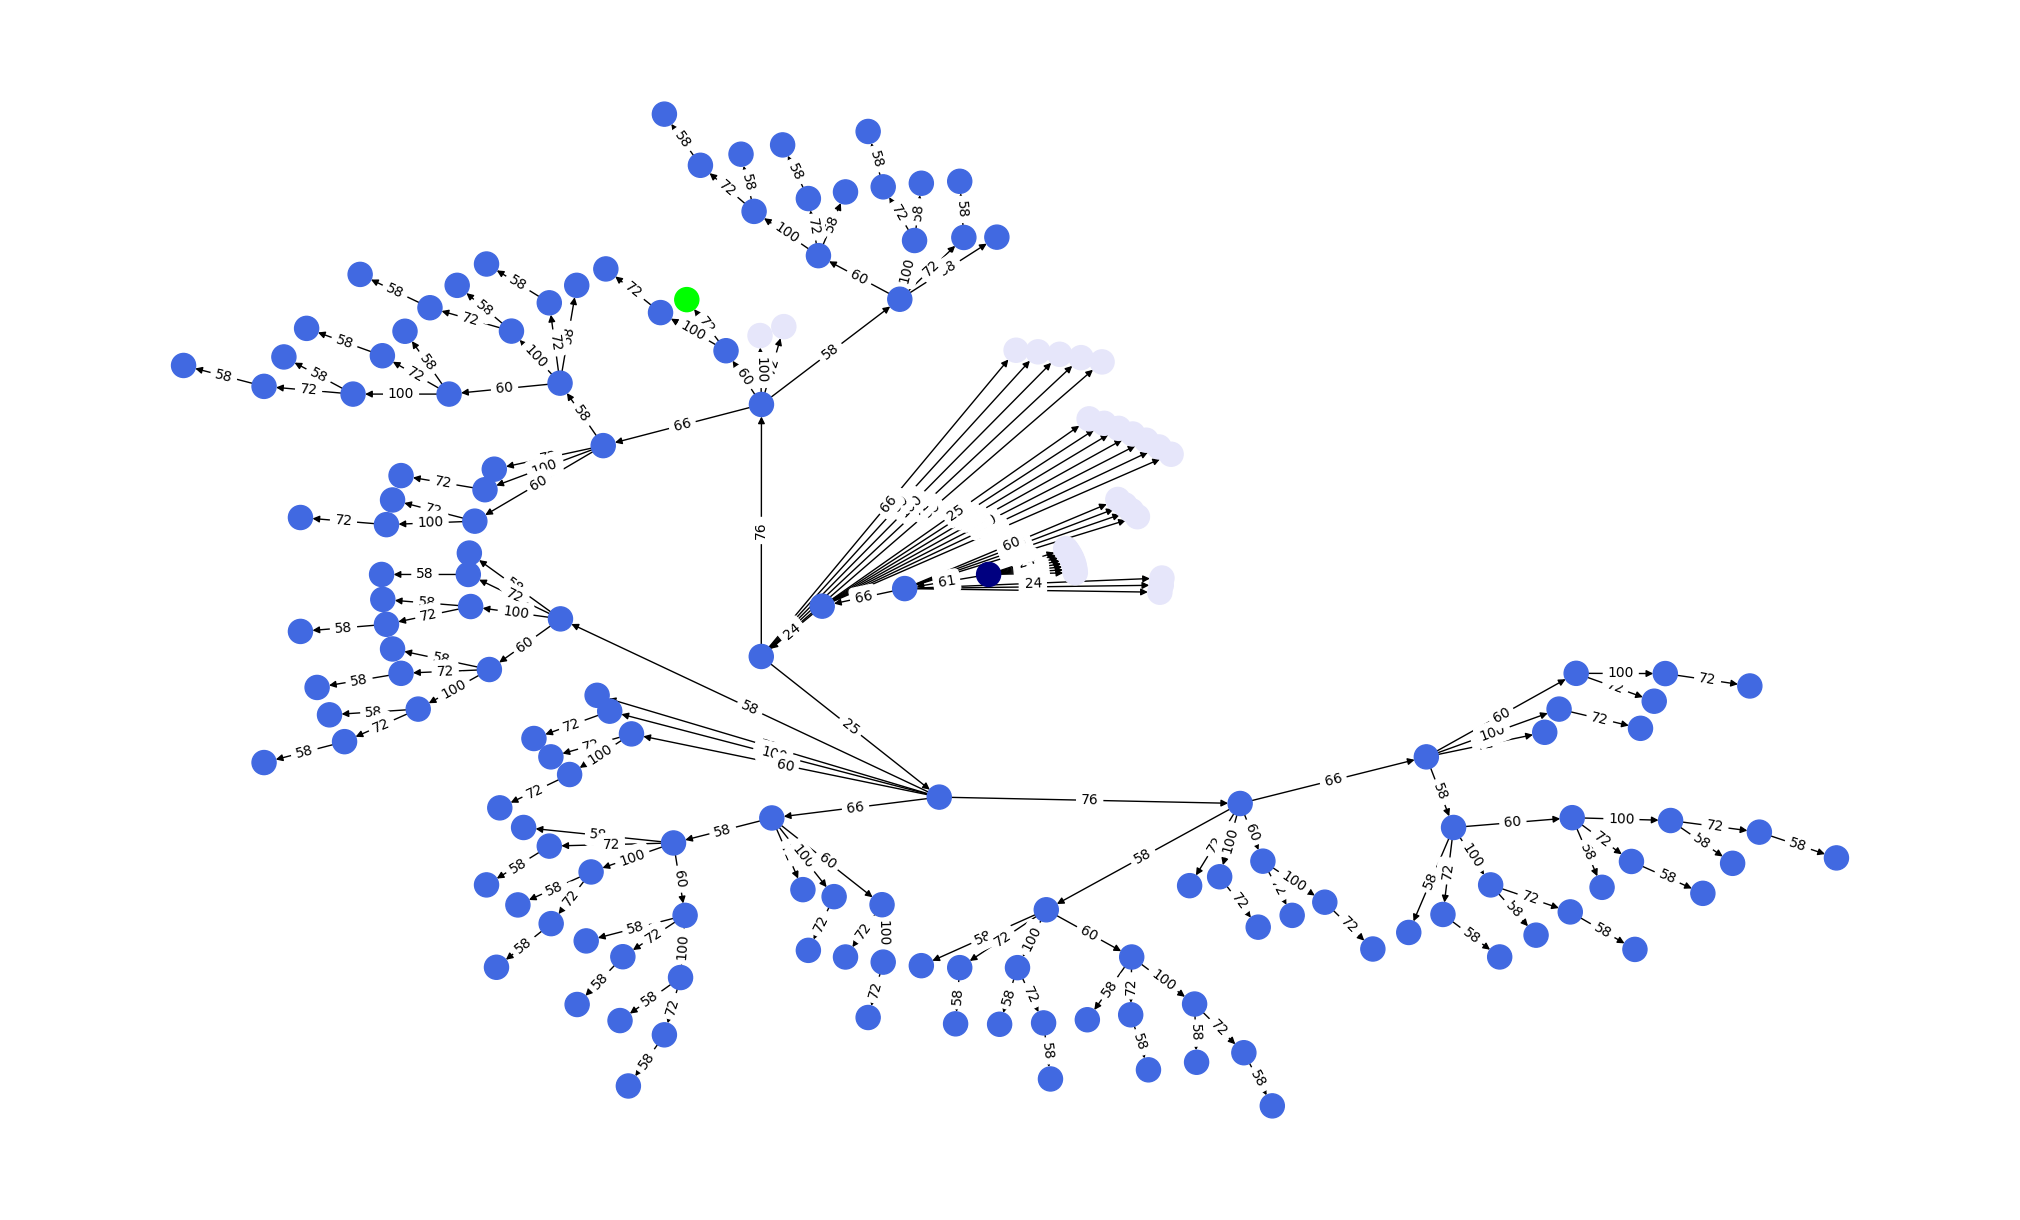

In [9]:
array, goal = problem(11)
search_tree = tree_search_df(array, goal, bound=False)

plt.figure(figsize=(20, 12))
pos = graphviz_layout(search_tree, prog="twopi")  # dot neato twopi circo fdp sfdp
nx.draw(
    search_tree,
    pos=pos,
    node_color=[c for _, c in search_tree.nodes(data="color")],
    # node_size=[90+100*c for _, c in search_tree.nodes(data='count')],
    with_labels=False,
)
nx.draw_networkx_edge_labels(search_tree, pos=pos, edge_labels=nx.get_edge_attributes(search_tree, "label"))
None

Found a solution in 430 steps
	(24, 60, 61, 66, 72, 76)


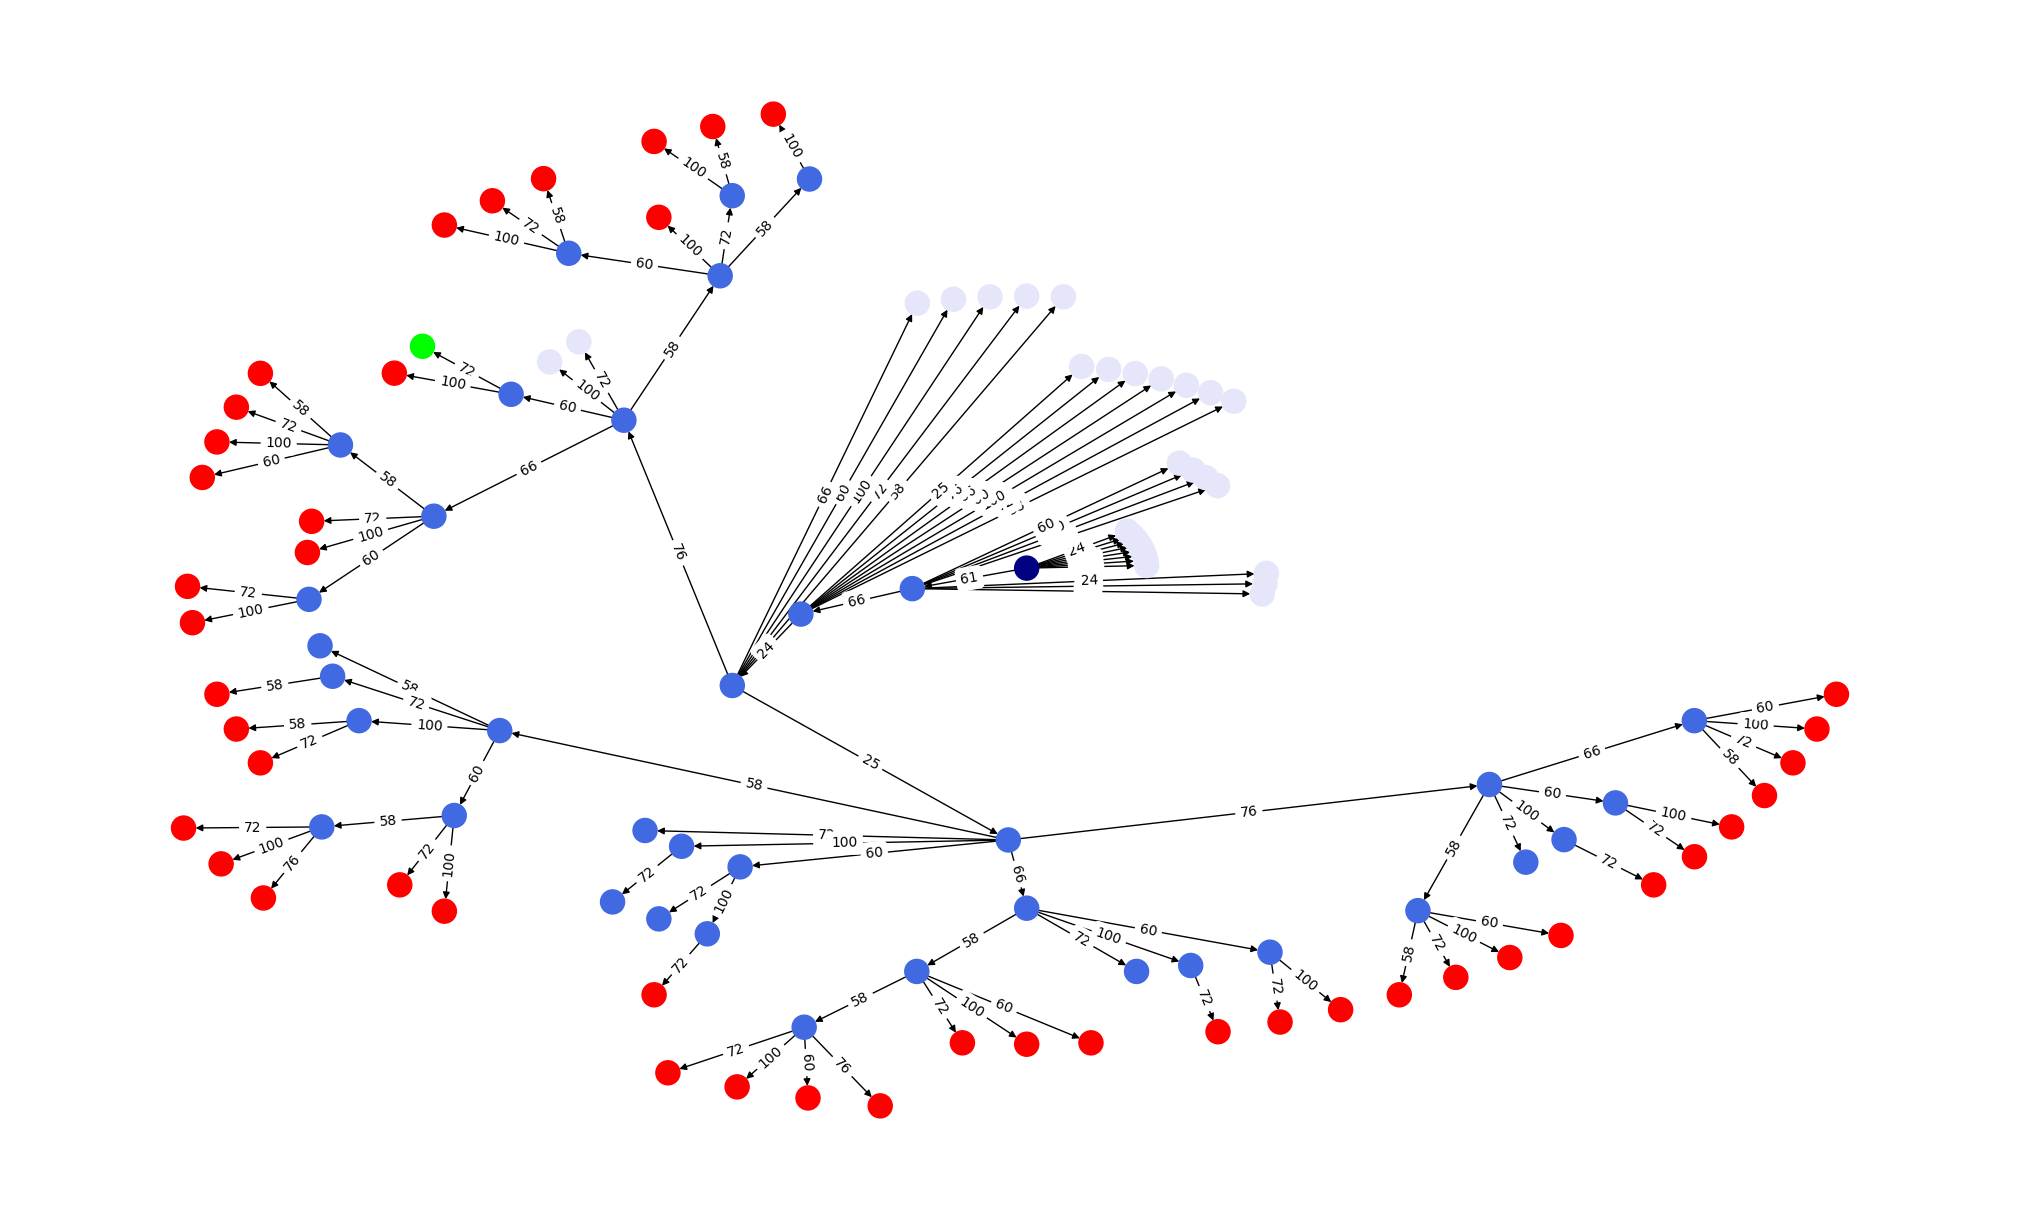

In [10]:
search_tree = tree_search_df(array, goal, bound=True)

plt.figure(figsize=(20, 12))
pos = graphviz_layout(search_tree, prog="twopi")  # dot neato twopi circo fdp sfdp
nx.draw(
    search_tree,
    pos=pos,
    node_color=[c for _, c in search_tree.nodes(data="color")],
    # node_size=[90+100*c for _, c in search_tree.nodes(data='count')],
    with_labels=False,
)
nx.draw_networkx_edge_labels(search_tree, pos=pos, edge_labels=nx.get_edge_attributes(search_tree, "label"))
None